IA & Data science -- 2017-2018
--------
*&copy; Equipe pédagogique: Ludovic Denoyer, Thibault Laugel, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander*

# TD-TME08: algorithme des k-moyennes

L'objectif de ce TP est d'implémenter un nouvel algorithme d'apprentissage non-supervisé, l'algorithme des K-moyennes (cours 9).

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Harb Hassan
Chrétien Clément 

## Questions de cours (à faire chez vous, sur papier)

Pour vous entraîner sans machine...

**[Q]** On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

**[Q]** Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 

**[Q]** Appliquer, à la main, l'algorithme des K-moyennes sur les données fournies sur le transparent 10 du cours 8 en utilisant d'abord $K=2$, puis $K=3$. Dans chacun des cas, réaliser au maximum 10 itérations de l'algorithme ($t_{max}=10$).
Comparer les résultats obtenus.


---

## Préparation

Décompresser l'archive, elle crée le répertoire "tp8" qui contient un fichier ipython à ouvrir (ce fichier-ci) et un sous-répertoire "data" contenant les bases d'apprentissage utilisées dans ce TP.

Le but de ce TP est de compléter ce document ipython en ajoutant les fonctions demandées. Avant de commencer, exécuter le bloc suivant afin de pouvoir initialiser des variables utiles 


In [704]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

### Chargement du fichier "base_2D.csv"

La lecture d'un fichier CSV par <code>pd.read()</code> fournit un DataFrame que vous avez appris à manipuler dans le TP02.

In [705]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D[0:5]  # ou bien: data_2D[0:len(data_2D)]

,X,Y
0,0,4.0
1,1,3.5
2,1,1.0
3,2,1.0
4,2,2.0


Dans la suite de ce TP, il est conseillé de travailler sur des données de type DataFrame le plus souvent possible.

**Important**: dans la suite de ce TP, on appelle:

- "base d'apprentissage" le DataFrame contenant l'ensemble des exemples d'apprentissage chargés par la commande précédente
- "base d'exemples" : un DataFrame contenant un ensemble d'exemples (remarque: la base d'apprentissage est le plus grand ensemble d'exemples possible)

### Récupération des fonctions utiles

**[Q]** Réécrire la fonction <code>normalisation()</code> du TD-TME07: cette fonction doit prendre en argument un <code>DataFrame DF</code> et rendre **le dataframe** obtenu en normalisant chaque colonne de <code>DF</code> par la méthode vue en cours 8.

In [706]:
def normalisation(DataFrame):
    min=[]
    max=[]

    for i in DataFrame.columns:
        min.append(DataFrame[i].min())
        max.append(DataFrame[i].max())

    matrice = DataFrame.as_matrix()
    
    for j in range (matrice.shape[0]):
        for k in range(matrice.shape[1]):

            matrice[j][k]=(matrice[j][k]-min[k])*1.0/(max[k]-min[k])       
    return  pd.DataFrame(matrice, columns=["X", "Y"])

('---> type de DataFnorm:', <class 'pandas.core.frame.DataFrame'>)


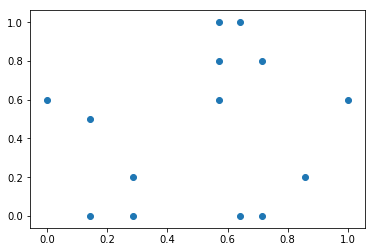

In [707]:
# Affichage des points après normalisation:

DataFnorm = normalisation(data_2D)
print("---> type de DataFnorm:",type(DataFnorm))

plt.scatter(DataFnorm["X"],DataFnorm["Y"])

Avec un dataframe, il est facile d'accéder à tous les éléments d'une colonne, par exemple '<code>DFnorm['X']</code> permet de récupérer une <code>Series</code> contenant toutes les lignes de la colonne de nom 'X'.
On peut accéder à une ligne (ou un ensemble de ligne) très facilement:
- <code>DFnorm.iloc[0]</code> permet de récupérer la ligne d'indice 0 sous la forme d'une "series"
- <code>DFnorm.iloc[0:1]</code> permet de récupérer la ligne d'indice 0 sous la forme d'un dataframe (cettte instruction réalise un "slicing")
- <code>DFnorm.iloc[0:5]</code> permet de récupérer les lignes d'indice de 0 à 4

etc.

In [708]:
print(type(DataFnorm.iloc[0]))
print("new:",type(DataFnorm.iloc[0]))
print("new:",type(DataFnorm.iloc[0:1]))

<class 'pandas.core.series.Series'>
('new:', <class 'pandas.core.series.Series'>)
('new:', <class 'pandas.core.frame.DataFrame'>)


**[Q]** Réécrire la fonction <code>dist_vect()</code> qui calcule la distance euclidienne entre deux <code>Series</code>.

In [709]:
import math

def dist_vect(x1, x2):
    s = 0
    for i in range(len(x1)):
        s += (x2.ix[i] - x1.ix[i])**2 
    return math.sqrt(s)

In [710]:
dist_vect(DataFnorm.iloc[0],DataFnorm.iloc[7])

0.6975174637562116

### Calcul de centroides

**[Q]** Ecrire la fonction <code>centroide()</code> qui, étant donné un DataFrame représentant plusieurs exemples rend le centroide. Cette fonction doit rendre un DataFrame.

In [711]:
def centroide(df):
    n = [[]]
    for i in df:
        n[0].append(df[i].mean())
    return pd.DataFrame(n, columns=["X", "Y"])

In [712]:
centroide(DataFnorm)

,X,Y
0,0.510204,0.45


## Travail à réaliser

### Inertie d'un cluster
**[Q]** Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un DataFrame contenant un ensemble d'exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [713]:
def inertie_cluster(df):
    c = centroide(df)
    s = 0
    
    for j in range(len(df)):
        #print [df["X"][j], df["Y"][j]], "dist :", dist_vect(center, [df["X"][j], df["Y"][j]])
        s += dist_vect(c.iloc[0], df.iloc[j])**2
    return s

In [714]:
print("inertie :",inertie_cluster(DataFnorm))

('inertie :', 2.975991253644316)


Dans ce qui suit, on appelle "ensemble de centroides" un DataFrame contenant $K$ vecteurs de dimensions $p$.

**[Q]** Ecrire la fonction <code>initialisation()</code> qui étant donné un entier $K>1$ et une base d'apprentissage (sous la forme d'un DataFrame) de $n$ exemples rend un DataFrame contenant $K$ exemples tirés aléatoirement dans la base.
On fait l'hypothèse que $K\leq n$.

*Remarque*: étudier les fonctions de la librairie random de Python...


In [715]:
import random 

def initialisation(k, df):
    l = random.sample([i for i in range(len(df))], k)
    new_df = pd.DataFrame([[df["X"][i], df["Y"][i]] for i in l], index=[i for i in range(k)], columns=df.columns)
    return new_df

In [716]:
# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = initialisation(3,DataFnorm)
Centroides_test

,X,Y
0,0.285714,0.0
1,0.285714,0.2
2,0.714286,0.8


En utilisant l'option <code>"color='blue'"</code> ou <code>"color='red'"</code> de la fonction <code>scatter()<code>, on peut réaliser l'affichage de la base d'apprentissage (en bleu) et des centroides initiaux (en rouge).

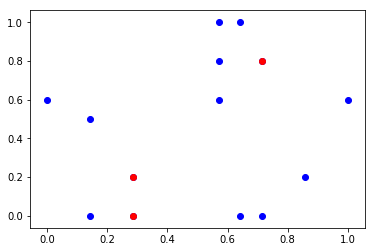

In [717]:
plt.scatter(DataFnorm['X'],DataFnorm['Y'],color='blue')
plt.scatter(Centroides_test['X'],Centroides_test['Y'],color='red')

**[Q]** Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un DataFrame contenant un ensemble de centroides, rend l'indice (dans le DataFrame) du centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [718]:
def plus_proche(ex, df):
    mini = 100000000000
    indice = -1
    for i in range(len(df.index)):
        dist  = dist_vect(df.iloc[i], ex)
        if dist < mini:
            mini = dist
            indice = i
    return indice

In [719]:
for i in range(len(DataFnorm)):
    pproche = plus_proche(DataFnorm.iloc[i],Centroides_test)
    print "Exemple ",i,": (",DataFnorm.iloc[i]['X'],", ",DataFnorm.iloc[i]['Y'], ")",\
          "est plus proche du centroide",pproche, ": (",Centroides_test.ix[pproche]['X'],", ", \
          Centroides_test.ix[pproche]['Y'],")"

Exemple  0 : ( 0.0 ,  0.6 ) est plus proche du centroide 1 : ( 0.2857142857142857 ,  0.2 )
Exemple  1 : ( 0.14285714285714285 ,  0.5 ) est plus proche du centroide 1 : ( 0.2857142857142857 ,  0.2 )
Exemple  2 : ( 0.14285714285714285 ,  0.0 ) est plus proche du centroide 0 : ( 0.2857142857142857 ,  0.0 )
Exemple  3 : ( 0.2857142857142857 ,  0.0 ) est plus proche du centroide 0 : ( 0.2857142857142857 ,  0.0 )
Exemple  4 : ( 0.2857142857142857 ,  0.2 ) est plus proche du centroide 1 : ( 0.2857142857142857 ,  0.2 )
Exemple  5 : ( 0.5714285714285714 ,  0.6 ) est plus proche du centroide 2 : ( 0.7142857142857143 ,  0.8 )
Exemple  6 : ( 0.5714285714285714 ,  0.8 ) est plus proche du centroide 2 : ( 0.7142857142857143 ,  0.8 )
Exemple  7 : ( 0.5714285714285714 ,  1.0 ) est plus proche du centroide 2 : ( 0.7142857142857143 ,  0.8 )
Exemple  8 : ( 0.6428571428571429 ,  0.0 ) est plus proche du centroide 0 : ( 0.2857142857142857 ,  0.0 )
Exemple  9 : ( 0.6428571428571429 ,  1.0 ) est plus proche 

### Matrice d'affectation

Etant donné une base d'apprentissage, on peut représenter une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) telle que 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


#### Question 2
**[Q]** Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

- Soit C l'ensemble des clusters, et E l'ensemble des exemples, alors on a pour tout c_0 ... c_n appartenant à C, |c_0 union c_1 union ... c_n| = |E| 
- Soit C l'ensemble des clusters, alors on a pour tout c appartenant à C, |c| > 0. 

#### Implémentation en Python
Dans ce TP, nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux K indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


**[Q]** Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [742]:
def affecte_cluster(bd, c):
    ma = {}
    for i in c.index:
        ma[i] = []
    for i in range(len(bd)):
        ex = pd.DataFrame(bd.ix[i]).transpose()
        ma[plus_proche(ex.iloc[0], c)].append(i)
    return ma
    

In [729]:
DictAffect = affecte_cluster(DataFnorm, Centroides_test)
DictAffect

{0: [], 1: [], 2: []}



{0: [2, 3, 8, 10], 1: [0, 1, 4, 12], 2: [5, 6, 7, 9, 11, 13]}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

**[Q]** Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [722]:
def nouveaux_centroides(bd, ma):
    new_centroide = pd.DataFrame(columns=bd.columns)
    for i, j in ma.items():
        df = pd.DataFrame(columns=bd.columns)
        for k in j:
            df = df.append(bd.iloc[k], ignore_index=True)
        new_centroide = new_centroide.append(centroide(df).iloc[0], ignore_index=True)
    return new_centroide

In [723]:
nouveaux_centroides(DataFnorm, DictAffect)

,X,Y
0,0.446429,0.000
1,0.321429,0.375
2,0.678571,0.800


### Inertie globale d'une partition

**[Q]** En utilisant la fonction <code>inertie_cluster()</code>, écrire la fonction <code>inertie_globale()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [724]:
def inertie_globale(bd, ma):
    s = 0
    for i, j in ma.items():
        df = pd.DataFrame(columns = bd.columns)
        for k in j:
            df = df.append(bd.iloc[k], ignore_index=True)
        s += inertie_cluster(df)
    return s

In [725]:
inertie_globale(DataFnorm,DictAffect)

1.079591836734694

### Algorithme des K-moyennes

**[Q]** En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* servira de critère de convergence, et l'entier *iter_max* sera utilisé pour fixer un nombre d'itérations maximale servant à arrêter le calcul.

In [745]:
def kmoyennes(k, df, epsilon, iter_max):
    centroides = initialisation(k, df)
    ig_actuel = 0
    ig_suivant = 0
    for i in range(iter_max):
        ig_actuel = ig_suivant
        ma = affecte_cluster(df, centroides)
        centroides = nouveaux_centroides(df, ma)
        ig_suivant = inertie_globale(df, ma)
        print "iteration", i, "\tInertie :\t",  ig_actuel, "Difference :\t", ig_suivant - ig_actuel
        if abs(ig_suivant - ig_actuel) < epsilon:
            return centroides, ma
    return centroides, ma

In [746]:
les_centres, l_affectation = kmoyennes(2, DataFnorm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

iteration 0 	Inertie :	0 Difference :	1.39209183673
iteration 1 	Inertie :	1.39209183673 Difference :	0.0
('Affichage des centres: ',           X       Y
0  0.678571  0.8000
1  0.383929  0.1875)
('Affichage des affectations: ', {0: [5, 6, 7, 9, 11, 13], 1: [0, 1, 2, 3, 4, 8, 10, 12]})


In [747]:
les_centres, l_affectation = kmoyennes(3, DataFnorm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

iteration 0 	Inertie :	0 Difference :	1.08918853256
iteration 1 	Inertie :	1.08918853256 Difference :	-0.307930029155
iteration 2 	Inertie :	0.781258503401 Difference :	0.0
('Affichage des centres: ',           X         Y
0  0.488095  0.066667
1  0.678571  0.800000
2  0.071429  0.550000)
('Affichage des affectations: ', {0: [2, 3, 4, 8, 10, 12], 1: [5, 6, 7, 9, 11, 13], 2: [0, 1]})


On peut réaliser un affichage couleur des centroïdes trouvés:

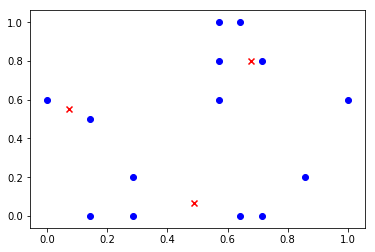

In [748]:
plt.scatter(DataFnorm['X'],DataFnorm['Y'],color='b')
plt.scatter(les_centres['X'],les_centres['Y'],color='r',marker='x')

**[Q]** Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K vaut 3).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

In [760]:
def affiche_resultat(bd, lc, ma):
    col = ["b", "g", "orange"]
    c = 0
    plt.scatter(les_centres['X'],lc['Y'],color='r',marker='x')
    for i, j in ma.items():
        df = pd.DataFrame(columns = bd.columns)
        for k in j:
            df = df.append(bd.iloc[k], ignore_index=True)
        plt.scatter(df['X'], df['Y'], color=col[c])
        c += 1

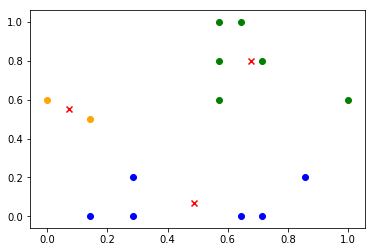

In [761]:
affiche_resultat(DataFnorm,les_centres,l_affectation)

Empty DataFrame
Columns: [X, Y]
Index: []
       X    Y         0         1
0    NaN  NaN  4.495598  2.433951
1    NaN  NaN  6.311316  4.578272
2    NaN  NaN  5.900835  8.427770
3    NaN  NaN  4.475988  8.209689
4    NaN  NaN  4.069812  0.250248
5    NaN  NaN  4.541196  5.373787
6    NaN  NaN  4.360782  2.636431
7    NaN  NaN  4.812234  9.094190
8    NaN  NaN  3.346729  7.466096
9    NaN  NaN  7.614617  4.691248
10   NaN  NaN  5.526504  5.034421
11   NaN  NaN  2.709565  5.322473
12   NaN  NaN  3.149828  8.039704
13   NaN  NaN  6.648479  6.625750
14   NaN  NaN  0.958169  5.739051
15   NaN  NaN  4.014174  8.674155
16   NaN  NaN  3.909801  7.362584
17   NaN  NaN  4.476602  0.531518
18   NaN  NaN  4.182888  4.600387
19   NaN  NaN  7.376654  5.218223
20   NaN  NaN  1.388177  6.854699
21   NaN  NaN  3.489148  4.978292
22   NaN  NaN  3.610469  3.269663
23   NaN  NaN  2.313642  6.921851
24   NaN  NaN  6.647905  5.480022
25   NaN  NaN  5.430045  3.305369
26   NaN  NaN  6.667190  7.496713
27   N

AssertionError: 4 columns passed, passed data had 2 columns

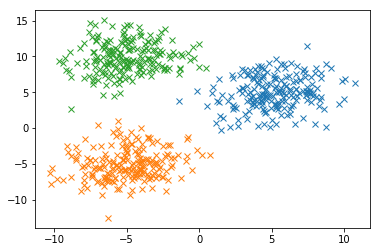

In [776]:
# Création des deux gaussiennes 
mean1 = [5, 5]
mean2 = [-5, -5]
mean3 = [-5, 10]
cov = [[5, 1], [1, 5]]  # diagonal covariance
mat1 = np.random.multivariate_normal(mean1, cov, 200).T
mat2 = np.random.multivariate_normal(mean2, cov, 200).T
mat3 = np.random.multivariate_normal(mean3, cov, 200).T

#Affichage
plt.plot(mat1[0], mat1[1], 'x')
plt.plot(mat2[0], mat2[1], 'x')
plt.plot(mat3[0], mat3[1], 'x')

df = pd.DataFrame(columns=['X', 'Y'])
print df
for i in range(len(mat1[0])):
    df = df.append(pd.Series([mat1[0][i], mat1[1][i]]), ignore_index=True)
    #df = df.append(pd.DataFrame([mat2[0][i], mat2[1][i]], columns=df.columns), ignore_index=True)
    #df = df.append(pd.DataFrame([mat3[0][i], mat3[1][i]], columns=df.columns), ignore_index=True)
print df  
les_centres, l_affectation = kmoyennes(3, df, 0.01, 1000)
affiche_resultat(DataFnorm,les_centres,l_affectation)

### Expérimentations

**[Q]** Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.

## Application à des données réelles

- Appliquer l'algorithme aux données concernant les déchets de la ville de Paris (qui sont fournies dans le répertoire data)
- Trouver des bases d'apprentissage intéressantes sur http://opendata.paris.fr/


Dans les 2 cas, étudier la base et les clusters qui peuvent être mis en évidence. En particulier, regarder la variation de l'inertie globale des clusters obtenus en fonction de la valeur de $K$ choisie.


**Attention**: il faudra certainement préparer cette base afin de pouvoir appliquer l'algorithme de clustering: en particulier, certaines colonnes (Granularité, Total...) ne sont pas à utilisables dans le calcul des distances, il faudra donc les éliminer. Il faut aussi prévoir de conserver le nom de l'arrondissement afin de pouvoir à la fin analyser le résultat du clustering.